<a href="https://colab.research.google.com/github/Timecapp/XAI_Capstone/blob/main/LIME_CNN_IDC_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Deep Learning in Breast Cancer Prediction
## Understanding Convolutional Neural Network Prediction Results in Healthcare

Advanced machine learning models (e.g., Random Forest, deep learning models, etc.) are generally considerred not explainable [1][2]. Those models largely remain black boxes. As described in [1][2], understanding the reasons behind the prediction results of the advanced machine learning models for healthcare is very important in assessing trust if a doctor plans to take cancer treatment action based on a prediction result. In [2], I used the Wisconsin Breast Cancer Diagnosis (WBCD) tabular dataset to present how to use the Local Interpretable Model-agnostic Explanations (LIME) method to explain the prediction results of a Random Forest model in breast cancer diagonasis. 

In this article, I use the Kaggle Breast Cancer Histology Images dataset [5] to demonstrate how to use LIME to explain the prediction results of a 2D [Convolutional Neural Network (ConvNet)](https://en.wikipedia.org/wiki/Convolutional_neural_network) in the Invasive Ductal Carcinoma (IDC) breast cancer diagonasis.

## 1. Preparing Breast Cancer Histology Images Dataset

The Breast Cancer Histology Images dataset [5] can be downloaded from [Kaggle](https://www.kaggle.com/kernels/scriptcontent/2064134/data).

As described in [5], the dataset consists of 5,547 50x50 pixel RGB digital images of H&E-stained breast histopathology samples. These images are labeled as either IDC or non-IDC. There are 2,788 IDC images and 2,759 non-IDC images. Those images have already been transformed into Numpy arrays and stored in the X.npy file. Similarly the corresponding labels are stored in the Y.npy file in Numpy array format. 


## 2. Training Convolutional Neural Network Model

The IDC dataset is an image classification issue and thus a 2D convolutional neural network is selected for IDC prediction.


## 3. Explaining Model Prediction Results Using LIME 

As described before, I use LIME to explain the ConvNet model prediction results in this article.


## References

[1] M. T. Ribeiro, S. Singh, and C. Guestrin, [“Why Should I Trust You?”
Explaining the Predictions of Any Classifier](https://arxiv.org/pdf/1602.04938.pdf)

[2] Yu Huang, [Explainable Machine Learning for Healthcare](https://towardsdatascience.com/explainable-machine-learning-for-healthcare-7e408f8e5130)

[3] [LIME tutorial on image classificatipn](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb)

[4] [Interpretable Machine Learning, A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/)

[5] [Predicting IDC in Breast Cancer Histology Images](https://www.kaggle.com/paultimothymooney/predicting-idc-in-breast-cancer-histology-images/data)


In [ ]:
import random
import numpy as np
import pandas as pd
import copy

np_load_old = np.load # save np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

from skimage.segmentation import mark_boundaries
import matplotlib.pylab as plt

import itertools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
#from keras.optimizers import RMSprop
from tensorflow.keras import optimizers
#from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

%matplotlib inline

In [ ]:
random.seed(42)
np.random.seed(42)

In [ ]:
EPOCH_SIZE = 70
BATCH_SIZE = 128

### 1.1 Loading Data

Once the X.npy and Y.npy files are downloaded into a local computer, they can be loaded into memory as Numpy arrays as follows:

In [ ]:
X = np.load('./X.npy') # images
Y = np.load('./Y.npy') # labels associated to images (0 = Non IDC, 1 = IDC)
type(X), type(Y), X.shape, Y.shape

(numpy.ndarray, numpy.ndarray, (5547, 50, 50, 3), (5547,))

### 1.2 Shuffling Data

In the original dataset files, all the data samples labeled as 0 (Non IDC) are put before the data samples labeled as 1 (IDC). To avoid artificial data patterns, the dataset is randomly shuffled as follows:

In [ ]:
indices = np.arange(Y.shape[0])
np.random.shuffle(indices)
indices = list(indices)
X = X[indices]
Y = Y[indices]

In [ ]:
Y[:20]

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0])

The following are two of the data samples, the image on the left is labeled as 0 (Non IDC) and the image on the right is labeled as 1 (IDC).

Text(0.5, 1.0, 'IDC: 1')

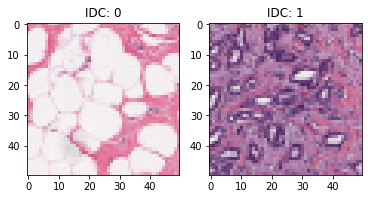

In [ ]:
IDC_0_sample = X[12].copy() 
IDC_1_sample = X[10].copy()

plt.subplot(1, 2, 1)
plt.imshow(IDC_0_sample, interpolation = 'none')
plt.title('IDC: 0')

plt.subplot(1, 2, 2)
plt.imshow(IDC_1_sample, interpolation = 'none')
plt.title('IDC: 1')

### 1.3 Transforming Dataset

The value of each pixel in an IDC image is in the range of [0, 255], while a typical deep learning model works the best when the value of input data is in the range of [0. 1] or [-1, 1]. The class Scale below is to transform the pixel value of IDC images into the range of [0, 1].

In [ ]:
class Scale(BaseEstimator, TransformerMixin):
    """
    Scale the pixel value of an image into the range of [0, 1]
    """
    def __init__(self):
        pass 
       
     # call this on model training (pipline.fit)     
    def fit(self, X, y):
       # print('Scale fit ...')
        return self
    
    # call this on model training (pipline.fit) and in sample prediction explainer
    def transform(self, X): 
       # print('Scale transform ...')
        X1 = X.copy()
        X1 = X1 / 255.0
        return X1

### 1.4 Dividing Dataset for Model Training and Testing

The dataset is divided into two parts, 80% for model training and 20% for model testing.

In [ ]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, Y, test_size=0.2)

X_train_data = copy.deepcopy(X_train_raw)
X_val   = X_train_data[:1000]
# X_val   = X_val / 255.0

X_train = X_train_data[1000:]
X_test  = copy.deepcopy(X_test_raw)

y_train_data = copy.deepcopy(y_train_raw)
y_val   = y_train_data[:1000]
y_train = y_train_data[1000:]
y_test  = y_test_raw.copy()

print("Training X Data Shape:", X_train.shape)
print("Validation X Data Shape:", X_val.shape)
print("Testing X Data Shape:", X_test.shape)

print("Training y Data Shape:", y_train.shape)
print("Validation y Data Shape:", y_val.shape)
print("Testing y Data Shape:", y_test.shape)

Training X Data Shape: (3437, 50, 50, 3)
Validation X Data Shape: (1000, 50, 50, 3)
Testing X Data Shape: (1110, 50, 50, 3)
Training y Data Shape: (3437,)
Validation y Data Shape: (1000,)
Testing y Data Shape: (1110,)


### 2.1 Creating 2D Convolutional Neural Network

Similarly to [5], the function getKerasCNNModel() below creates a 2D ConvNet for the IDC image classification.  

### 2.2 Creating Pipeline Component

The class KerasCNN is to wrapper the 2D ConvNet model as a sklearn pipeline component so that it can be combined with other data preprocessing components when necessary. For example, the IDC image preprocessing can be a separate component.

In [ ]:
def getKerasCNNModel():
    batch_size = BATCH_SIZE
    epochs = EPOCH_SIZE  
    img_rows, img_cols = X_train.shape[1], X_train.shape[2]
    input_shape = (img_rows, img_cols, 3) 
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    model.add(Dropout(0.25)) 
    model.add(Conv2D(32, (3,3),  activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    model.add(Dropout(0.25)) 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss= keras.losses.binary_crossentropy, 
                  optimizer=keras.optimizers.RMSprop(), 
                  metrics=['accuracy'])
    
    return model
  
    
class KerasCNN(BaseEstimator, TransformerMixin):
    """
    Wrapper for turning Keras CNN model into pipeline fit and predict_prob without transform
    """
    def __init__(self, X_val=None, y_val=None):
        self._model      = getKerasCNNModel()
        self._batch_size = BATCH_SIZE
        self._epochs     = EPOCH_SIZE
        self._X_val      = X_val / 255.0
        self._y_val      = y_val
    
    # call this in model traiing (pipline.fix)
    def fit(self, X, y):  
        print('KerasCNN fit ...')
        self.history = self._model.fit(X, y,
                        batch_size=self._batch_size,
                        verbose=1,
                        epochs=self._epochs,
                        validation_data=(self._X_val, self._y_val))
        return self
    
    # not get call
    def transform(self, X): 
        print('KerasCNN transform: do nothing')
        return X

     # call this in sample prediction explainer
    def predict_proba(self, X):
       # print('KerasCNN predict_proba ...')
        y_pred = self._model.predict(X) 
        return y_pred  
    
    # call on testing     
    def evaluate(self, X, y):
        print('KerasCNN evaluate ...')
        return self._model.evaluate(X,y)        

### 3.1 Setting Up a Pipeline

Similarly to [1][2], I make a pipeline to wrapper the ConvNet model for the integration with LIME API.

In [ ]:
from sklearn.pipeline import Pipeline 

simple_cnn_pipeline = Pipeline([
    ('scale', Scale()),
    ('CNN', KerasCNN(X_val=X_val, y_val=y_val))
    ])

### 3.2 Training the ConvNet Model

The ConvNet model is trained as follows so that it can be called by LIME for model prediction. 

In [ ]:
%%time
simple_cnn_pipeline.fit(X_train, y_train)

KerasCNN fit ...
Epoch 1/70
27/27 [==============================] - 8s 260ms/step - loss: 0.8182 - accuracy: 0.5153 - val_loss: 0.6794 - val_accuracy: 0.6140
Epoch 2/70
27/27 [==============================] - 7s 258ms/step - loss: 0.6727 - accuracy: 0.6093 - val_loss: 0.6558 - val_accuracy: 0.6260
Epoch 3/70
27/27 [==============================] - 7s 256ms/step - loss: 0.6539 - accuracy: 0.6296 - val_loss: 0.6531 - val_accuracy: 0.7030
Epoch 4/70
27/27 [==============================] - 8s 307ms/step - loss: 0.6451 - accuracy: 0.6613 - val_loss: 0.6107 - val_accuracy: 0.7130
Epoch 5/70
27/27 [==============================] - 7s 255ms/step - loss: 0.6066 - accuracy: 0.6820 - val_loss: 0.5866 - val_accuracy: 0.7310
Epoch 6/70
27/27 [==============================] - 7s 254ms/step - loss: 0.6049 - accuracy: 0.6919 - val_loss: 0.5872 - val_accuracy: 0.7390
Epoch 7/70
27/27 [==============================] - 7s 254ms/step - loss: 0.6084 - accuracy: 0.6849 - val_loss: 0.5924 - val_accura

AttributeError: ignored

AttributeError: ignored

In [ ]:
CNN = simple_cnn_pipeline['CNN']
history = CNN.history

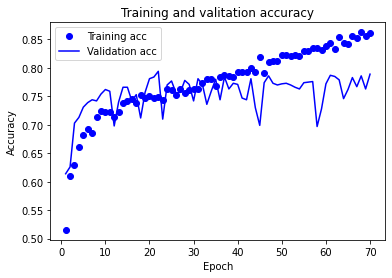

In [ ]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc,'b', label='Validation acc')
plt.title('Training and valitation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 7.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=61b3c162cae94ddd1eeb55a5c7fc1deece622a842c07777cd512686aa4516310
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [ ]:
%reload_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

### 3.3 Selecting LIME Explainer

As described in [2], the LIME method supports different types of machine learning model explainers for different types of datasets such as image, text, tabular data, etc. The LIME image explainer is selected because the dataset are images. 

The 2D image segmentation algorithm [Quickshift](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html) is used for generating LIME super pixels (i.e., segments) [1]. 

In [ ]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer() 

segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [ ]:
X_test_copy = X_test.copy()
test_loss, test_acc = CNN.evaluate(X_test_copy, y_test)
print('Test acc: ', test_acc)

KerasCNN evaluate ...
35/35 [==============================] - 2s 40ms/step - loss: 147.1996 - accuracy: 0.6153
Test acc:  0.615315318107605


In [ ]:
y_pred = simple_cnn_pipeline.predict_proba(X_test_copy)
print('y_pred shape: ', y_pred.shape)

35/35 [==============================] - 2s 44ms/step
y_pred shape:  (1110, 1)


In [ ]:
class_0_indices = []
class_1_indices = []

for i in range(y_pred.shape[0]):
    j = 1 if y_pred[i] > 0.5 else 0
    
    if y_test[i] == 1 and j == 1:
        class_1_indices.append(i)
        
    if y_test[i] == 0 and j == 0:
        class_0_indices.append(i)

Text(0.5, 1.0, 'IDC: 1')

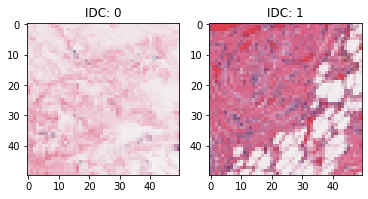

In [ ]:
# two testing samples to be explained
plt.subplot(1, 2, 1)

IDC_0_sample_idx = class_0_indices[26] 
IDC_0_sample_test = X_test_copy[IDC_0_sample_idx] 

plt.imshow(IDC_0_sample_test,
           interpolation = 'none')
plt.title('IDC: {}'.format(y_test_raw[IDC_0_sample_idx]))


plt.subplot(1, 2, 2)

IDC_1_sample_idx = class_1_indices[8] 
IDC_1_sample_test =  X_test_copy[IDC_1_sample_idx]

plt.imshow(IDC_1_sample_test, 
           interpolation = 'none')
plt.title('IDC: {}'.format(y_test_raw[IDC_1_sample_idx]))

### 3.4 Explaining Model Prediction

Once the ConvNet model has been trained, given an original IDC image, the explain_instance() method of the LIME explainer can be called to generate an explanation of the model prediction. 

An explanation of an image prediction consists of a template image and a corresponding mask image. These images can be used to explain a ConvNet model prediction result in different ways. 

In [ ]:
%%time
'''
Hide color is the color for a superpixel turned OFF. Alternatively, 
if it is NONE, the superpixel will be replaced by the average of its pixels
'''
explanation_1 = explainer.explain_instance(IDC_1_sample_test, 
                                         classifier_fn = simple_cnn_pipeline.predict_proba, 
                                         top_labels=2, 
                                         hide_color=0, # 0 - gray 
                                         num_samples=10000,
                                         segmentation_fn=segmenter
                                        )

  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
CPU times: user 1min 12s, sys: 2.27 s, total: 1min 14s
Wall time: 1min 21s


Text(0.5, 1.0, 'IDC: 1')

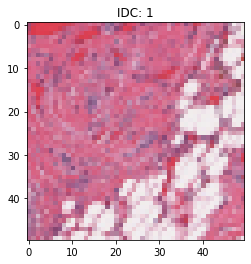

In [ ]:
fig, ax1 = plt.subplots(1, 1)

ax1.imshow(IDC_1_sample_test, interpolation = 'none')

ax1.set_title('IDC: 1')

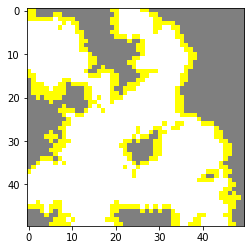

In [ ]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation_1.get_image_and_mask(explanation_1.top_labels[0], 
                                            positive_only=True, 
                                            num_features=20, 
                                            hide_rest=True)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

explanation 1 top labels[0] =  0


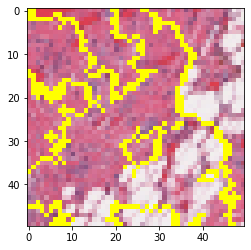

In [ ]:
temp, mask = explanation_1.get_image_and_mask(explanation_1.top_labels[0], 
                                            positive_only=True, 
                                            num_features=20, 
                                            hide_rest=False)

print('explanation 1 top labels[0] = ', explanation_1.top_labels[0])
plt.imshow(mark_boundaries(temp, mask))

In [ ]:
%%time
'''
Hide color is the color for a superpixel turned OFF. Alternatively, 
if it is NONE, the superpixel will be replaced by the average of its pixels
'''
explanation_2 = explainer.explain_instance(IDC_0_sample_test, 
                                         classifier_fn = simple_cnn_pipeline.predict_proba, 
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=10000,
                                         segmentation_fn=segmenter
                                        )

  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
CPU times: user 1min 11s, sys: 2.31 s, total: 1min 14s
Wall time: 1min 19s


Text(0.5, 1.0, 'IDC: 0')

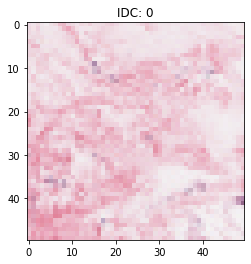

In [ ]:
fig, ax1 = plt.subplots(1,1)

ax1.imshow(X_test_raw[IDC_0_sample_idx], interpolation = 'none')

ax1.set_title('IDC: 0')

explanation 2 top labels[0] =  0


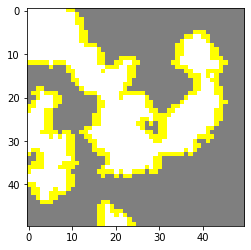

In [ ]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation_2.get_image_and_mask(explanation_2.top_labels[0], 
                                            positive_only=True, 
                                            num_features=20, 
                                            hide_rest=True)

print('explanation 2 top labels[0] = ', explanation_2.top_labels[0])
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

explanation 2 top labels[0] =  0


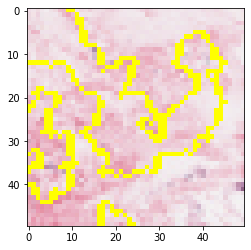

In [ ]:
temp, mask = explanation_2.get_image_and_mask(explanation_2.top_labels[0], 
                                            positive_only=True, 
                                            num_features=20, 
                                            hide_rest=False)
print('explanation 2 top labels[0] = ', explanation_2.top_labels[0])
plt.imshow(mark_boundaries(temp, mask))